<a href="https://colab.research.google.com/github/yiyinglai/Pneumonia/blob/master/Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# %tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from keras.utils import plot_model
import matplotlib.pyplot as plt
from scipy import interp
import numpy as np
import tqdm
import math
import cv2
import os
! pip install git+https://github.com/divamgupta/image-segmentation-keras.git

  Cloning https://github.com/divamgupta/image-segmentation-keras.git to /tmp/pip-req-build-i1ww8p4e
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras.git /tmp/pip-req-build-i1ww8p4e
     |████████████████████████████████| 28.3MB 1.5MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=39858 sha256=6a8b4d724e248437cd08054470f3ab7f2acce1ec15e39a5b7a3b235f31ccd5e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-hhevm6dr/wheels/0a/4e/8b/d3f9088958a351a72f48ede4558836b78a03c0c124f81f41ed
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


In [0]:
# move dataset to colab space
!cp -r "/content/gdrive/My Drive/ECE1512/stage1/" /content/

In [0]:
# GENERATORS FOR model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

train_directory = '/content/stage1/train'
validation_directory = '/content/stage1/validation'
test_directory = '/content/stage1/test'
CLASSES = ['normal', 'pneumonia']

image_size = (299, 299)

# train image generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=image_size,
                                                    batch_size=16,
                                                    shuffle=True,
                                                    classes=CLASSES)
unique, train_counts = np.unique(train_generator.labels, return_counts=True)
train_size = train_counts.sum()
# validation image generator
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=10,
                                        horizontal_flip=True,
                                        vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=image_size,
                                                    batch_size=16,
                                                    shuffle=True,
                                                    classes=CLASSES)
unique, validation_counts = np.unique(validation_generator.labels, return_counts=True)
validation_size = validation_counts.sum()
# test image generator
test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                  class_mode='categorical',
                                                  interpolation='bilinear',
                                                  target_size=image_size,
                                                  batch_size=16,
                                                  shuffle=False,
                                                  classes=CLASSES)
unique, test_counts = np.unique(test_generator.labels, return_counts=True)
test_size = test_counts.sum()

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
print(class_weights)

Found 4108 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 879 images belonging to 2 classes.
{'normal': 0, 'pneumonia': 1}
{'normal': 0, 'pneumonia': 1}
{'normal': 0, 'pneumonia': 1}
[1.83885407 0.68672685]


**Inceptionv3**

In [0]:
# LOAD PRETRAINED MODEL InceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge

# create the base pre-trained model
inceptionv3 = InceptionV3(weights='imagenet', include_top=True)
# nasnetlarge = NASNetLarge(weights='imagenet', include_top=False, pooling='avg', classes=2)

Using TensorFlow backend.















96116736/96112376 [==============================] - 1s 0us/step


In [0]:
# BUILD NEW CLASSIFICATION MODEL BASED ON inceptionv3
import tensorflow
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Input, Dense, Lambda
from keras import metrics
from keras.backend import resize_images
import cv2

y = inceptionv3.layers[-2].output
outputs = Dense(2, activation='sigmoid')(y)

# this is the model we will train
model1 = Model(inputs=inceptionv3.inputs, outputs=outputs)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in inceptionv3.layers:
  layer.trainable = False
for layer in model1.layers:
  layer.trainable = True

adam = Adam()
# compile the model (should be done *after* setting layers to non-trainable)
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
# model1.summary()

In [0]:
plot_model(inceptionv3, show_shapes=True)

In [0]:
# TRAIN model
from math import ceil, floor
from keras.callbacks import ModelCheckpoint

# train the model on the new data for a few epochs
steps_per_epoch = ceil(train_size/16)
validation_steps = ceil(validation_size/16)

history_model1 = model1.fit_generator(train_generator, epochs=17, verbose=1, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              validation_freq=1,
                              class_weight=class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/17
257/257 [==============================] - 201s 783ms/step - loss: 0.2573 - categorical_accuracy: 0.9028 - val_loss: 1.1830 - val_categorical_accuracy: 0.5866
Epoch 2/17
257/257 [==============================] - 180s 699ms/step - loss: 0.1840 - categorical_accuracy: 0.9317 - val_loss: 0.3959 - val_categorical_accuracy: 0.8850
Epoch 3/17
257/257 [==============================] - 179s 698ms/step - loss: 0.1519 - categorical_accuracy: 0.9417 - val_loss: 0.1508 - val_categorical_accuracy: 0.9328
Epoch 4/17
257/257 [==============================] - 180s 700ms/step - loss: 0.1534 - categorical_accuracy: 0.9419 - val_loss: 0.3241 - val_categorical_accuracy: 0.9100
Epoch 5/17
257/257 [==============================] - 181s 703ms/step - loss: 0.1353 - categorical_accuracy: 0.9484 - val_loss: 0.0960 - val_categorical_accuracy: 0.9624
Epoch 6/17
257/257 [==============================] - 

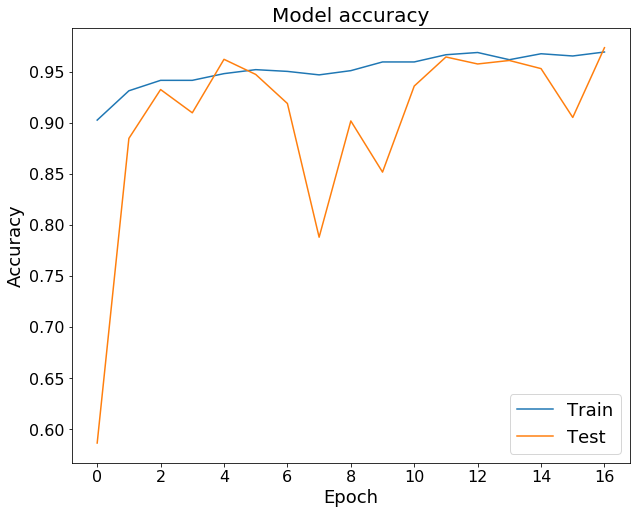

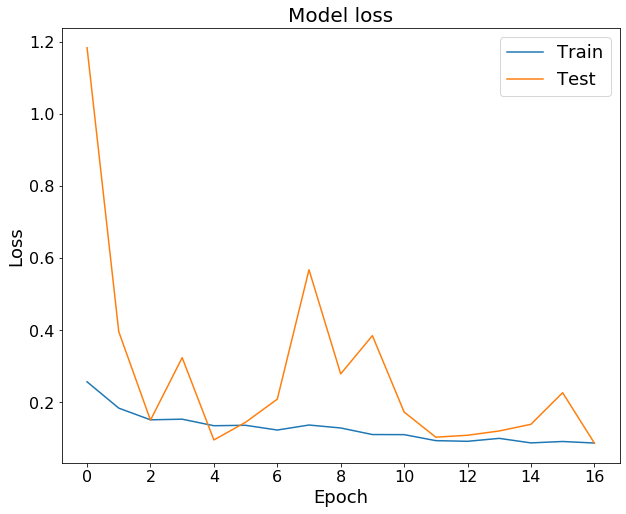

In [0]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10, 8))
plt.plot(history_model1.history['categorical_accuracy'])
plt.plot(history_model1.history['val_categorical_accuracy'])
plt.title('Model accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(['Train', 'Test'], loc='lower right',fontsize=18)
plt.show()
fig.savefig('/content/gdrive/My Drive/ECE1512/stage1/model1/model1_history_accuracy_17epoch.jpeg')

# Plot training & validation loss values
fig = plt.figure(figsize=(10, 8))
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(['Train', 'Test'], loc='upper right',fontsize=18)
plt.show()
fig.savefig('/content/gdrive/My Drive/ECE1512/stage1/model1/model1_history_loss_17epoch.jpeg')

In [0]:
results = model1.predict_generator(test_generator)
print(results)

[[9.5013738e-01 4.9448669e-02]
 [9.2607355e-01 3.4079224e-02]
 [6.9273394e-01 3.1093687e-01]
 ...
 [1.2814999e-06 1.0000000e+00]
 [1.1713207e-03 1.0000000e+00]
 [2.7673910e-04 1.0000000e+00]]


In [0]:
pred_scores = model1.predict(test_generator)
y_pred = np.argmax(pred_scores,axis=1)
print(y_pred)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
model1.save('/content/gdrive/My Drive/ECE1512/stage1/model1/model1_17epochs.h5')

In [0]:
import pandas as pd
hist_df = pd.DataFrame(history_model1.history)

# save to json:  
hist_json_file = '/content/gdrive/My Drive/ECE1512/stage1/model1/history_model1_17epochs.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [0]:
import pandas as pd
import json

with open('/content/gdrive/My Drive/ECE1512/stage1/model1/history_model1.json', 'r') as f:
  data = json.load(f)
history_model1 = pd.DataFrame(data)

In [0]:
eval_results = model1.evaluate_generator(test_generator)
print(eval_results)

[0.19561535670963434, 0.9158134244814667]


In [0]:
from sklearn.metrics import classification_report, precision_score, precision_score, f1_score

pred = model1.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
print(classification_report(test_generator.labels, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

      normal       0.94      0.76      0.84       238
   pneumonia       0.92      0.98      0.95       641

    accuracy                           0.92       879
   macro avg       0.93      0.87      0.90       879
weighted avg       0.92      0.92      0.92       879

